# ADAlyzers final project.


### Structure of the notebook.


1. Introduction.
    - What is the project about
        - Questions, etc.
    - How will we solve the problem?
2. Data description + processing.
    - General overview
        - Size of data
        - Types of data
    - Data cleaning
        - Decisions: Explain everything leading to final dataframe.
3. Featurizing. For each item: Intro + data analysis + methods.
    - Semantic similarity
    - Positional encoding
        - Images
        - Relative to paragraph
    - Curvature
4. Statistical analysis.
    - Matching
    - Tests
    - Conclusions.

---

# 1. Introduction.

Players show attitudes and follow various strategies.

Is the implementation of some peculiar strategy correlated with success in this game? Or better, can we recommend a particular strategy to play Wikispeedia game?

Here, we will answer these questions by exploring a database of over 100k recorded games from real users, by using tools from natural language processing, web scrapping and network analysis, among others.

---

# 2. Data description + processing


The methodology chosen for the data processing step is to perform a **matching analysis** with the final objective to test if specific players' game strategies lead to success in the Wikispeedia game. 


A logistic regression is conducted with the goal to estimate the parameters of the logistic model with the dependent binary variable being the success, and the independent variables being sequentially extracted the following set of features (different players' choices when playing the Wikispeedia game):

1. **Positioning** of the clicked hyperlinks;
2. Clicking hyperlinks in **image captions**;
3. Clicking articles with the following **semantic similarity patterns**:
   -  increasing semantic similarity along the path between articles and the target article;
   -  increasing semantic similarity along the path between two sequentially clicked articles.
   
Several **confounders** may affect the outcome of the regression analysis i.e. of the potentially found correlation between the aforementioned features and success. <br>
To mention a few, the **“difficulty”** of the randomly assigned task (source and target articles), affects the players' successfulness together with the strategy adopted to address it. This “difficulty” could be naively measured by **shortest path distance** between the source and target article in the Wikispeedia hyperlinks graph (calculated with the Floyd-Warshall algorithm). <br>

Additionally, **characteristics** of the human paths, likely independent of the strategy and dynamic, as they change by virtue of the hyperlinks clicked (i.e. with the development of the game), may also impact the final outcome. The **"similarity"** of paths can be assessed by computing the "player agnostic", path-specific features. More precisely, the local features of the edges in the wikipedia graph: adjacent nodes' in- and out- degrees, and derived quantities. 

In order to remove the aforementioned confounders, the dataset is filtered and the matching is performed accordingly with the assumptions made. 

Players are matched on same **shortest path distance** of the assigned task, and maximum **propensity score** (see __Statistical analysis__), with the **treated subject** being the user performing a specific strategy (e.g. clicking more frequently than the average on hyperlinks showing up in images’ captions) and the **controlled subject** being the user NOT performing the strategy. 

The analysis challenge can be reformulated as follows: **"being assigned an equally difficult task, and having played a similar game, are players more successful if they adopt some specific strategy?"**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.parse
import seaborn as sns
import os, sys

In [2]:
data_path = "data/"
parent_folder_path = data_path + 'wikispeedia_paths-and-graph/'

paths_finished_df=(pd.read_csv(os.path.join(parent_folder_path, 'paths_finished.tsv'), 
                               sep='\t', skiprows=15, header=None)
                   .rename(columns={0:"ip",
                                    1:"timestamp",
                                    2:"duration",
                                    3:"path",
                                    4:"rating"}))

paths_unfinished_df=(pd.read_csv(os.path.join(parent_folder_path, 'paths_unfinished.tsv'), 
                               sep='\t', skiprows=16, header=None)
                     .rename(columns={0:"ip",
                                      1:"timestamp",
                                      2:"duration",
                                      3:"path",
                                      4:"target",
                                      5:"type"}))
articles_df=pd.read_csv(os.path.join(parent_folder_path, 'articles.tsv'), 
                        sep='\t', skiprows=12, header=None, names=['article'])


# Get a list of article names.

import urllib.parse
def str_url_format(word):
    """
    Article name preprocessing.
    
    Preprocessing of article names (url encoded)
    """
    return (urllib.parse.unquote(word)
            .replace("_", " ")
            .strip()
            .lower())

article_names_cleaned = (pd.read_csv(data_path + 'wikispeedia_paths-and-graph/articles.tsv', 
                                     sep='\t', 
                                     skiprows=11,
                                     header=None)[0]
                         .apply(str_url_format)
                         .values
                         .tolist()
                        )

article_names_cleaned[:3]

['áedán mac gabráin', 'åland', 'édouard manet']

#### Load `successful` and `unsuccessful` paths. For each path, find the shortest distance from the `source` to the `target`

In [3]:
# first read the shortest path matrix
shortest_path_matrix = []

with open(data_path + 'wikispeedia_paths-and-graph/shortest-path-distance-matrix.txt', 'r') as f:
    # the first 17 lines (indexed from 0) is the file description 
    for line in f.readlines()[17:]:
        shortest_path_matrix.append(line)
        
# the matrix now stores all shortest paths from all source articles
print('{0} articles make up the Wikispeedia hypertextual graph.'.format(len(shortest_path_matrix)))

4604 articles make up the Wikispeedia hypertextual graph.


In [4]:
# for each human path, perform the following steps:
#      1. extract the source and target article
#      2. find the *index* in the article names list that corresponds to the source and target article
#      3. the corresponding *index* row in the shortest path matrix corresponds to the source article. 
#         from this list of numbers, use the target article *index* to find the *shortest path length*

def augment_with_shortest_path(df: pd.DataFrame, successful: bool) -> pd.DataFrame:
    """
    this function takes a Series and returns a DataFrame with the following columns:
       1. path
       2. source article
       3. target article
       4. shortest path length
       
    input:
       df: the Pandas DataFrame containing all the human navigation paths
       successful: a boolean indicating whether the paths were successful or not
    """
    # remove all paths with back-tracks
    df = df[~df['path'].str.contains('<')]        
    paths, human_path_lengths, source_articles, target_articles, shortest_paths = [], [], [], [], []
    
    # all information required for successful paths is in the path itself
    if successful:
        for human_path in df['path']:

            split_path = str_url_format(human_path).split(";")
            
            paths.append(";".join(split_path))
            # subtract 1 because we do not count the source article
            human_path_lengths.append(len(split_path)-1)

            source = split_path[0]
            target = split_path[-1]
            source_articles.append(source)
            target_articles.append(target)
    
    # unsuccessful paths require extraction of the target article from a separate column
    else:
        for human_path, target in zip(df['path'], df['target']):
            
            split_path = str_url_format(human_path).split(";")
            paths.append(";".join(split_path))
            # subtract 1 because we do not count the source article
            human_path_lengths.append(len(split_path)-1)

            source = split_path[0]
            target = str_url_format(target)
            source_articles.append(source)
            target_articles.append(target)
        
    for source, target in zip(source_articles, target_articles):
        source_index = article_names_cleaned.index(source)
        # there are target articles that were not provided in the plain text files
        try:
            target_index = article_names_cleaned.index(target)
        except Exception:
            shortest_paths.append("N/A")
            continue
            
        # query the shortest path matrix to get the correct vector (corresponding to the source article)
        shortest_path_vector = shortest_path_matrix[source_index]
        # now find the target article indexed integer in the vector
        shortest = shortest_path_vector[target_index]
        # it's not always possible to get to the target article. Impossible navigation is denoted by "_"
        if shortest == "_":
            shortest_paths.append("Impossible")
        else:
            shortest_paths.append(int(shortest))
        
        
    # create the augmented DataFrame
    out = pd.DataFrame({
                      'path': paths,
                      'source_article': source_articles,
                      'target_article': target_articles,
                      'human_path_length': human_path_lengths,
                      'shortest_path_length': shortest_paths
                      })
    
    return out

In [5]:
### Load successful paths
successful_df = augment_with_shortest_path(df=paths_finished_df, successful=True)

### Load unsuccessful paths
unsuccessful_df = augment_with_shortest_path(df=paths_unfinished_df, successful=False)

### Data cleaning

In [6]:
# to investigate human behaviour, we remove all "Impossible paths" and also shortest_path_length = 0
successful_df = successful_df[(successful_df['shortest_path_length'].apply(lambda x: x != 'Impossible' and x != 0))]

# some unsuccesful paths only contain 1 article because the user didn't click anything, 
# these are less meaningful paths to analyze as we are interested in users who tried but failed

# human paths with length == 2 are not of interest as no sequential trend can be observed and "measured"

# we will keep paths where the human clicked at least 3 articles
successful_df = successful_df[(successful_df['human_path_length'].apply(lambda x: x >= 3))]

# some target articles for unsuccessful paths were not provided in the plain_text folder, denoted in
# the DataFrame as "N/A". Remove these
unsuccessful_df = (unsuccessful_df[(unsuccessful_df['shortest_path_length']
                                    .apply(lambda x: x != 'N/A' and x != 'Impossible'))])

unsuccessful_df = unsuccessful_df[(unsuccessful_df['human_path_length'].apply(lambda x: x >= 3))]



## General overview of the paths data

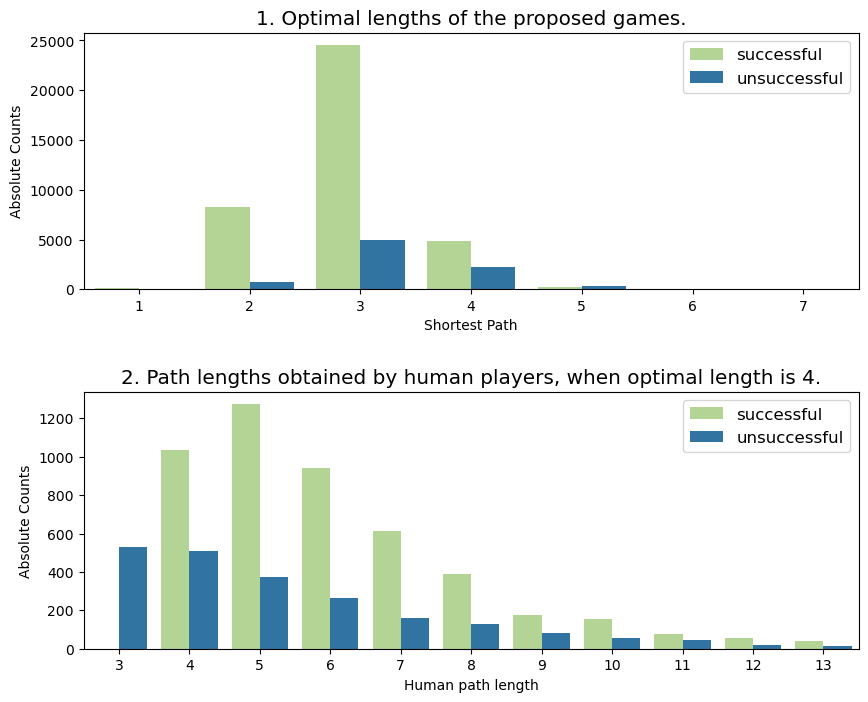

In [7]:
# take a look at the shortest_path distributions
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(2,1, 
                       figsize=(10,8), 
                       gridspec_kw={"hspace":0.4})
plt.rcParams["font.size"] = 12


successful_counts = (successful_df['shortest_path_length']
                     .value_counts()
                     .reset_index())
successful_counts["success"] = "successful"

unsuccessful_counts = (unsuccessful_df['shortest_path_length']
                       .value_counts()
                       .reset_index())
unsuccessful_counts["success"] = "unsuccessful"

all_counts = pd.concat([successful_counts, 
                        unsuccessful_counts], 
                       axis=0)

sns.barplot(data=all_counts, 
            x="index", 
            y="shortest_path_length", 
            hue="success",
            ax=ax[0], 
            palette=["#b2df8a", "#1f78b4"])

ax[0].set_ylabel('Absolute Counts'); 
ax[0].set_xlabel('Shortest Path');
ax[0].set_title("1. Optimal lengths of the proposed games.")
#Count of human paths, stratified by shortest possible path")

ax[0].legend(loc=1)
ax[0].set_ylabel('Absolute Counts') 
ax[0].set_xlabel('Shortest Path')



# Next plot: frequency by human length
n = 4
successful_human_path_lengths_n = (successful_df
                                   [successful_df['shortest_path_length'] == n]
                                   ['human_path_length']
                                   .value_counts()
                                   .reset_index())

successful_human_path_lengths_n["success"] = "successful"

unsuccessful_human_path_lengths_n = (unsuccessful_df
                                     [unsuccessful_df['shortest_path_length'] == n]
                                     ['human_path_length']
                                     .value_counts()
                                     .reset_index())

unsuccessful_human_path_lengths_n["success"] = "unsuccessful"

all_path_ln = pd.concat([successful_human_path_lengths_n,
                         unsuccessful_human_path_lengths_n])

sns.barplot(data=all_path_ln, 
            x="index", 
            y="human_path_length", 
            hue="success", 
            ax=ax[1],
            palette=["#b2df8a", "#1f78b4"])

ax[1].set_xlim(-0.5,10.5)

ax[1].set_ylabel('Absolute Counts')
ax[1].set_xlabel('Human path length')
ax[1].set_title(f"2. Path lengths obtained by human players, when optimal length is {n}.")
# Count of human path lengths, with shortest possible path = n");

ax[1].legend(loc=1);

`shortest_path_distance` is taken as a proxy to game difficuly. The first plot shows that, as difficulty increases, the class unbalance decreases. An OL of 5 is already too hard, and most paths are unsuccessful, however the data here is too scarce. As there is still enough data for `shortest_path_distance`==4, and the classes seem better balanced, we will center our attention on this subset of the data for the rest of the analysis.


The second plot above shows the length of the actual paths taken by humans, on the subset with `shortest_path_distance`==4. Successful paths have mostly a length of 5, but the distribution spreads to higher values. Distribution of unsuccessful paths is severely skewed to the left and peaks in 3, meaning that in such paths, players give up before even having a chance to win. This shows that the distribution of paths is very different for both populations, which leads us to conclude that we have to perform a matching study to draw any conclussions at all.


In [8]:
# add label encoding players' success
successful_df['is_successful'] = 1
unsuccessful_df['is_successful'] = 0

# merge the successful and unsuccessful DataFrames
final_df = pd.concat([successful_df, unsuccessful_df])
final_df.reset_index(drop=True, inplace=True)


# save the final DataFrame used for the analysis
final_df.to_csv('processed/final_df.csv', index=False)

final_df.head(3)
# next, we will calculate "treatments" involving semantic distance metrics for the DataFrame

,path,source_article,target_article,human_path_length,shortest_path_length,is_successful
0,14th century;15th century;16th century;pacific...,14th century,african slave trade,8,3,1
1,14th century;europe;africa;atlantic slave trad...,14th century,african slave trade,4,3,1
2,14th century;niger;nigeria;british empire;slav...,14th century,african slave trade,7,3,1


#### Next steps will augment the dataset with path specific features.

---

# 3. Featurization

<font color='red' size='5'>
Featurization a. Link clickability: positional encoding of hyperlinks.
</font>

#### Introduction.
Our first question is: is the relative position of a hyperlink within an article an indicator of success in a game? E.g. if the player clicks mostly links in image captions, or links that appear in the bottom of the page, are they more prone to win?

This comes from the heuristic that link positioning is an indirect way of classifying articles semantic content: in the top of the page we find more general, as well as more contextual concepts, while as we further read an article, relations between concepts become more specific.

---

To get the distribution of players' clickability preference with regard to the positioning of the hyperlinks throughout the article text, the following protocol is implemented:
1. parse Wikispeedia articles html files in order to get the **most frequent positioning*** per each hyperlink;
2. parse the **human paths** (i.e. sequence of clicked articles) and attribute to each link its most frequent positioning (on the basis of the categorization above);
3. group by **positioning**** and count the **number of occurences*****;
4. normalize;
5. plot the distributions of successful and unsuccessful players. 

\*each article is divided into paragraphs: on the basis of the relative (to the article length) paragraph the hyperlink shows up, it is assigned a categorical label, which indicates its positioning; then, to each hyperlink name, its most frequent label, throughout the Wikispeedia library, it is assigned. <br>
\*\*`positioning` is a categorical variable with possible labels `top`, `top-center`, `center`, `center-bottom`, `bottom`. <br>
\*\*\* do this separately for successful and unsuccessful players.


#### 1. Parse Wikispeedia articles

The full implementation of the code can be found in P2-Notebook.ipynb, here only the qualitative results are reported.  

`most_freq_positioning_df` stores the most frequent positionings for each hyperlink:

In [9]:
data_processed_folder = "processed/POS_IMG/"
most_freq_positioning_df=pd.read_csv(data_processed_folder+'most_freq_positioning_df.csv', index_col=0)
most_freq_positioning_df.tail()

,link,most_freq_positioning
10528,‘6 villages for 2006’,center-top
10529,“6 villages for 2006”,center
10530,€,center-bottom
10531,€25 million,top
10532,↑,center


#### 2. Parse human paths 

`links_freq_pos_f` and `links_freq_pos_u` store the frequency of players' clicks and the most frequent positioning per hyperlink (respectively for finished paths and unfinished paths, i.e. successful and not succesful players): 

In [10]:
links_freq_pos_f=pd.read_csv(data_processed_folder+'links_freq_pos_f.csv', index_col=0)
links_freq_pos_f[:10]

,link,#_clicks,most_freq_positioning
0,áedán mac gabráin,0.0,top
1,åland,1.0,bottom
2,édouard manet,1.0,center-bottom
3,éire,1.0,top
4,óengus i of the picts,0.0,center
5,€2 commemorative coins,1.0,center
6,10th century,66.0,top
7,11th century,82.0,top
8,12th century,95.0,top
9,13th century,82.0,top


#### 3. 4. 5. Count, normalize and plot

The **number of clicks** are grouped by the categorical variable _positioning_ and summed up. The number of clicks per _positioning_ are normalized by the total number of clicks; the **number of occurrencies** of hyperlinks in Wikispeedia articles are grouped by, summed up and normalized by the total number of clickable hyperlinks in the library. <br> 
The dataframes `succesful_pos_df` and `unsuccesful_pos_df` store hyperlinks' number of clicks `#_clicks`, number of occurrencies `nr`, both the values normalized `#_clicks_norm`, `nr_norm` and the latters' ratio **`#_clicks / #_hyperlinks`**, the result of our interest. 

In [11]:
succesful_pos_df=pd.read_csv(data_processed_folder+'vis_f.csv', index_col=0)
unsuccesful_pos_df=pd.read_csv(data_processed_folder+'vis_u.csv', index_col=0)
succesful_pos_df

,#_clicks,#_clicks_norm,nr,nr_norm,#_clicks / #_hyperlinks,is_successful
bottom,24085.0,0.099419,24193,0.184871,0.537775,1
center,20014.0,0.082615,20228,0.154573,0.534472,1
center-bottom,15623.0,0.064489,22588,0.172607,0.373620,1
center-top,18631.0,0.076906,23031,0.175992,0.436986,1
top,163904.0,0.676571,40824,0.311957,2.168792,1


The plot **`Distribution of clicks and hyperlinks positioning`** juxtaposes the distribution of players clicks per _positioning_ and the same for hyperlinks occurrencies in the Wikispeedia articles. `Distribution of clickability preference` visualizes the players preferences with regard to the hyperlinks positioning throughout the article text:


More precisely:

- a value of 1 ( **#_clicks/#_hyperlinks == 1** ) corresponds to a **hyperlinks clickability on average equally proportional to the normalized frequency of the specific categorical positioning** (i.e. the number of clicks proportional to the number of times a hyperlink shows up in a section of the article);
- a value of greater than 1, points a more than proportional clickability;
- a value of smaller than 1, points a less than proportional clickability.

**Successful** and **unsuccessful players preferences** are juxtaposed in the graph **`Distribution of clickability preference`**:

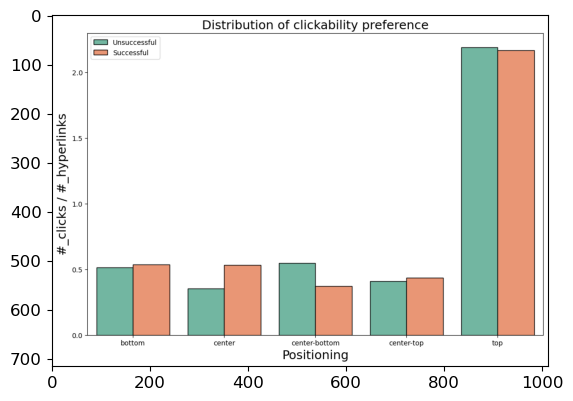

In [12]:
#determine which one is better
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread(data_processed_folder+'Distribution_clickability_preference_pos.png')
imgplot = plt.imshow(img)
plt.show()

There is an evident players' clickability preference for hyperlinks showing up at the **top of articles**, followed by a preference for **bottom** and center-bottom positionings. <br>
The **largest gap** between successful and unsuccessful is for the center-bottom-positioned hyperlinks: successful players click on average less than unsuccessful ones. They share this trend with top-positioned links, while the **trend** is **reversed** for bottom-, center- and center-top-positioned links. <br>
Center-positioned links are clicked the least, both by successful and unsuccessful players.

For further understanding of players' response to the game and the structure of the game itself, it's interesting to **test** whether clicking on a specific categorical positioning of the hyperlinks throughout the text **leads players to succeed** or not. The two behaviours that will be further investigated are clicking on top-positioned and bottom-positioned hyperlinks. The two are the trendiest among players and present reversed patterns w.r.t. successfulness: these reasons motivate the choice.

### Hyperlinks clickability: image captions

To get the distribution of players' clickability preference with regard to the positioning of the hyperlinks throughout the article text, the following protocol is implemented:
1. parse Wikispeedia articles html files in order to get the **list of hyperlinks** that show up **in image captions**;
2. parse the **human paths** (i.e. sequence of clicked articles) and count the clicked hyperlinks that show up in image captions (on the basis of the categorization above);
3. group by a hyperlink being in an **image captions*** or not and count the **number of occurences**;
4. normalize;
5. plot the distributions. 

\*`in_image` is a binary variable indicating whether the hyperlink shows up in image captions or not. 

#### 1. Parse Wikispeedia articles

The full implementation of the code can be found in P2-Notebook.ipynb, here only the qualitative results are reported.

`links_in_images_list` stores the list of links present in image captions:

In [13]:
link_in_img_list=pd.read_csv(data_processed_folder+'links_in_images_unique.csv', index_col=0).values[:,0].tolist()
link_in_img_list[:5]

['bangladesh', 'portsmouth', 'england', 'india', 'pompeii']

`link_in_image_freq_df` stores the number of occurrencies in image captions, throughout the Wikispeedia library,  per hyperlink.

In [14]:
link_in_image_freq_df=pd.read_csv(data_processed_folder+'link_in_img_freq_df.csv', index_col=0)
link_in_image_freq_df[:5]

,link,#_link_in_img
0,scientific classification,508
1,NaN,424
2,animalia,398
3,time zone,340
4,chordata,330


#### 2. 3. Parse human paths and count

`successful_img_df` and `unsuccessful_img_df` store the number of players' clicks `#_clicks`, a flag `in_image` specifying if the hyperlink shows up in an image caption, the occurrencies in image captions and in the articles `#_link_in_img`, `#_link_in_article` per hyperlink, computed for finished paths and unfinished paths (i.e. successful and unsuccessful players).

In [15]:
successful_img_df=pd.read_csv(data_processed_folder+'new_df_img_f.csv', index_col=0)
unsuccessful_img_df=pd.read_csv(data_processed_folder+'new_df_img_u.csv', index_col=0)
successful_img_df[:10]

,link,#_clicks,in_image,#_link_in_img,#_link_in_article
0,áedán mac gabráin,0,0,0.0,2.0
1,åland,1,1,1.0,4.0
2,édouard manet,1,1,1.0,10.0
3,éire,1,0,0.0,3.0
4,óengus i of the picts,0,0,0.0,0.0
5,€2 commemorative coins,1,0,0.0,0.0
6,10th century,66,0,0.0,37.0
7,11th century,82,1,1.0,29.0
8,12th century,95,0,0.0,59.0
9,13th century,82,0,0.0,59.0


####  4. 5. Normalize and plot

`successful_norm_df` and `unsuccessful_norm_df` store the normalized click frequency for hyperlinks in image captions and not. The normalization took into account that hyperlinks showing up in image captions also occur in article texts, therefore the frequency of clicks `#_clicks` was scaled to the relative occurrency in image caption to article text (`#_link_in_img`/`#_link_in_article`), and both were normalized to the total number of occurrencies in image captions or in article texts. The final dataframe with the aforementioned features is `final_img_df`. 

In [16]:
successful_norm_df=pd.read_csv(data_processed_folder+'links_freq_img_f_norm.csv', index_col=0)
successful_norm_df.head(10)

,link,#_clicks_norm,in_image
0,áedán mac gabráin,0.00,0
1,åland,1.00,1
2,édouard manet,0.60,1
3,éire,2.00,0
4,óengus i of the picts,0.00,0
5,€2 commemorative coins,2.00,0
6,10th century,132.00,0
7,11th century,5.66,1
8,12th century,190.00,0
9,13th century,5.56,1


In [17]:
final_img_df=pd.read_csv(data_processed_folder+'vis_img.csv', index_col=0)
final_img_df

,#_clicks_norm,#_clicks / #_links_img,is_successful
in_image,,,
0,193052.00,1.673866,1
1,132289.39,8.517764,1
0,57666.00,0.499996,0
1,45057.67,2.901144,0


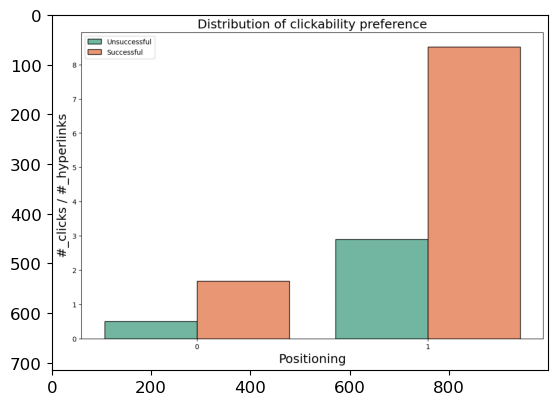

In [18]:
img = mpimg.imread(data_processed_folder+'Distribution_clickability_preference_img.png')
imgplot = plt.imshow(img)
plt.show()

It is evident that **clicking** hyperlinks showing up in **image captions** is a **trendy** behavior for Wikispeedia players, especially among the **successful**. The rate of successful players clicking on image captions is roughly 4 times the unsuccessful players one. It is of interest for our study to test if this peculiar strategy can lead Wikispeedia players to success. To this end a matched analysis will be conducted.

In [19]:
## Adding the features

def find_features(human_path):
    '''this function determines the categorical positioning feature of each hyperlink in the human path'''
    return [most_freq_positioning_df.loc[link].values.item() 
                         if link in most_freq_positioning_df.index \
                         else np.random.choice(['top', 'center-top','center','center-bottom', 'bottom'])
                         for link in human_path] #certain hyperlinks were not classified 

final_df_postioning = final_df['path'].apply(lambda x: x.split(";")).apply(lambda x: find_features(x))

def find_features_frequency(features):
    '''this function counts the frequency of the categorical positioning features of the hyperlinks in each human path'''
    t, ct, c, cb, b=[], [], [], [], []

    for path in features:
        t.append(path.count('top'))
        ct.append(path.count('center-top'))
        c.append(path.count('center'))
        cb.append(path.count('center-bottom'))
        b.append(path.count('bottom'))
    return pd.DataFrame({'top': t, 'center_top': ct, 'center': c, 'center_bottom': cb, 'bottom': b})

successful_features_freq = find_features_frequency(final_df_postioning)

final_df_feats = (pd.concat([final_df, 
                             successful_features_freq], 
                            axis=1)
                  .dropna())



#list of unique hyperlinks showing up in images'captions
link_in_img_list=(pd.read_csv(data_processed_folder+'links_in_img_tab_unique.csv', 
                              index_col=0)
                  .values[:,0]
                  .tolist())

#count number of hyperlinks in images' captions in each path
final_df_feats['count_images'] = (final_df['path']
                                 .apply(lambda x: x.split(";"))
                                 .apply(lambda x: np.isin(x, link_in_img_list).sum()
                                        if np.isin(x, link_in_img_list).sum() else 0)
                                )

final_df = final_df_feats

<font color='red' size='5'>
Featurization b. Semantic similarity Between Wikipedia Articles: 'Bag-of-Words' Cosine Similarity Based on Word Frequencies
</font>

We are interested in measuring ***similarity*** between `Wikipedia` articles to investigate players' strategies in `Wikispeedia`. The proposed similarity is `Cosine Similarity` measured on word frequencies given a pair of articles. **Therefore, the assumption we make is that articles with similar occurrences of words are similar.** 

In order to mitigate similarity due to common English words such as "the", we apply a filter as follows:

1. Remove all `Stop` words as defined in `Scikit-learn`
* https://scikit-learn.org/stable/modules/feature_extraction.html#nqy18

2. Remove all white spaces and `\n` characters


3. Apply a scaled version of word frequency count as implemented in `TfidfTransformer` in `Scikit-learn`: 
* https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html#sklearn.feature_extraction.text.TfidfTransformer

The cell blocks below show our data processing pipeline.

In [20]:
import os

data_path = 'data/'
base_path = data_path + 'plaintext_articles'
articles = os.listdir(base_path)
# sort the article names in alphabetical order. This is not strictly required
articles = sorted(articles)

def remove_duplicates_and_fix_names(articles: list):
    """this function parses all the articles provided in the plaintext folder and stores the
       names of all the articles after "cleaning" them (some articles containing accents have encoded names).
       The raw text from the files are also stored in a list after removing white spaces and empty lines."""
    
    def parse_text(article: str) -> str:
        """this helper function reads a raw text file and removes white spaces and empty lines."""
        with open(os.path.join(base_path, article)) as f:
            # remove white spaces
            raw_text = [line.rstrip() for line in f.readlines()]
            # remove empty lines
            raw_text = [line.strip() for line in raw_text if line != '']
            return str(raw_text)
    
    # some article names have errors - fix these
    article_names_cleaned, texts = [], []
    
    for art_name in articles:
        texts.append(parse_text(art_name))
        article_names_cleaned.append(str_url_format(art_name))
                    
    
    # remove ".txt" from the article names
    article_names_cleaned = [article.replace('.txt', '') for article in article_names_cleaned]
    # remove list bracket from string casting of raw text
    texts = [text.replace('[', '') for text in texts]
    
    return article_names_cleaned, texts

article_names_cleaned, texts = remove_duplicates_and_fix_names(articles)

In [21]:
# count word frequency using sklearn out-of-the-box functions
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pandas as pd
import numpy as np

# remove common stop words
tfid_vectorizer = TfidfVectorizer(stop_words='english')
# apply CountVectorizer and TfidfTransform sequentially
matrix = tfid_vectorizer.fit_transform(texts)
matrix = matrix.todense()

# by default, "TfidfVectorizer" uses l2 norm and thus, to obtain the Cosine Similarity,
# we simply perform a dot product of the matrix
cosine_sim = pd.DataFrame(np.dot(np.array(matrix), np.array(matrix).T), columns=article_names_cleaned)
# assign the index names also as the article names. This is used for easy querying pairs of articles
cosine_sim.index = article_names_cleaned        
cosine_sim

,áedán mac gabráin,åland,édouard manet,éire,óengus i of the picts,€2 commemorative coins,10th century,11th century,12th century,13th century,...,ziad jarrah,zimbabwe,zinc,zinc chloride,zion national park,zionism,zirconium,zoroaster,zuid-gelders,zulu
áedán mac gabráin,1.000000,0.003680,0.006182,0.047190,0.183846,0.004210,0.008076,0.012168,0.013427,0.011928,...,0.004239,0.006244,0.001843,0.002172,0.003523,0.006111,0.001494,0.008908,0.001593,0.012721
åland,0.003680,1.000000,0.008423,0.017851,0.004137,0.043866,0.007999,0.004936,0.004993,0.013233,...,0.004768,0.023149,0.002752,0.002160,0.007089,0.016041,0.003315,0.005287,0.008188,0.012883
édouard manet,0.006182,0.008423,1.000000,0.009609,0.006520,0.014643,0.011617,0.008879,0.011491,0.011438,...,0.010377,0.011835,0.004556,0.002780,0.011044,0.014414,0.004934,0.009887,0.005441,0.012838
éire,0.047190,0.017851,0.009609,1.000000,0.049035,0.033312,0.012264,0.008489,0.033374,0.015251,...,0.009314,0.038388,0.006863,0.005671,0.005486,0.031955,0.005751,0.012004,0.004430,0.019581
óengus i of the picts,0.183846,0.004137,0.006520,0.049035,1.000000,0.006741,0.012741,0.013508,0.020239,0.012106,...,0.004763,0.008280,0.002700,0.002718,0.005656,0.008067,0.001780,0.009081,0.001923,0.015018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zionism,0.006111,0.016041,0.014414,0.031955,0.008067,0.017812,0.019210,0.021355,0.024060,0.023037,...,0.012631,0.038386,0.007253,0.003734,0.028964,1.000000,0.006372,0.016985,0.004575,0.026654
zirconium,0.001494,0.003315,0.004934,0.005751,0.001780,0.006597,0.007255,0.005258,0.004183,0.005319,...,0.003589,0.010286,0.065117,0.038394,0.005937,0.006372,1.000000,0.005025,0.003256,0.004729
zoroaster,0.008908,0.005287,0.009887,0.012004,0.009081,0.010104,0.021481,0.019697,0.017953,0.024732,...,0.008748,0.014037,0.005008,0.003395,0.009401,0.016985,0.005025,1.000000,0.003077,0.011154
zuid-gelders,0.001593,0.008188,0.005441,0.004430,0.001923,0.005124,0.004908,0.004378,0.002217,0.004719,...,0.003414,0.008758,0.002613,0.002273,0.004882,0.004575,0.003256,0.003077,1.000000,0.008353


### To assess the quality of our results, we inspected some of the results in several ways.

First, let's see the distribution of similarity values.

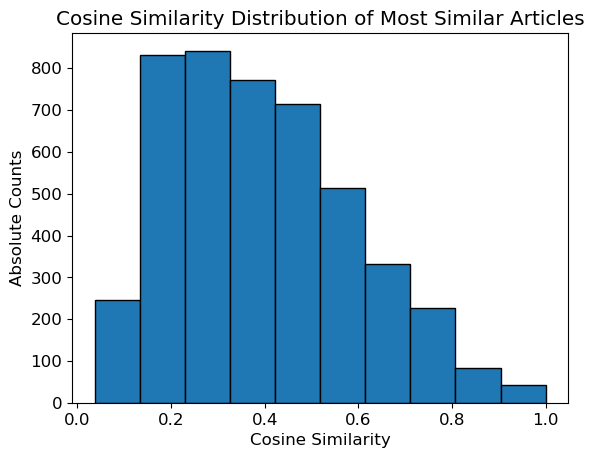

In [22]:
import matplotlib.pyplot as plt

# let's take a look at the Cosine Similarity distribution of the most similar article to a given article
most_similar = []
for idx in range(len(cosine_sim)):
    # index [-2] because index [-1] is always = 1 since it is a self similarity
    most_similar.append(sorted(cosine_sim.iloc[idx])[-2])
    
# plot the similarities
pd.Series(most_similar).plot(kind='hist', edgecolor='k')
plt.title("Cosine Similarity Distribution of Most Similar Articles")
plt.xlabel("Cosine Similarity"); plt.ylabel("Absolute Counts");

# there are no glaring red flags, e.g., most Cosine Similarities close to 0 or 1

In [23]:
#comment distribution of cosine similarity

Next, let's do clustermaps with some randomly selected articles. This should show high values of similarity for similar concepts (duh), but more than that, it gives us also a dendrogram connecting different concepts, which establishes a hierarchy of similarities.

As this is a semantic measure, our results should *make sense* based on our knowledge from the language. The plots below show good agreement with whatever we would expect for the selected examples, so we will use this measure of semantic similarity from now on.

TypeError: seaborn.matrix.heatmap() got multiple values for keyword argument 'ax'

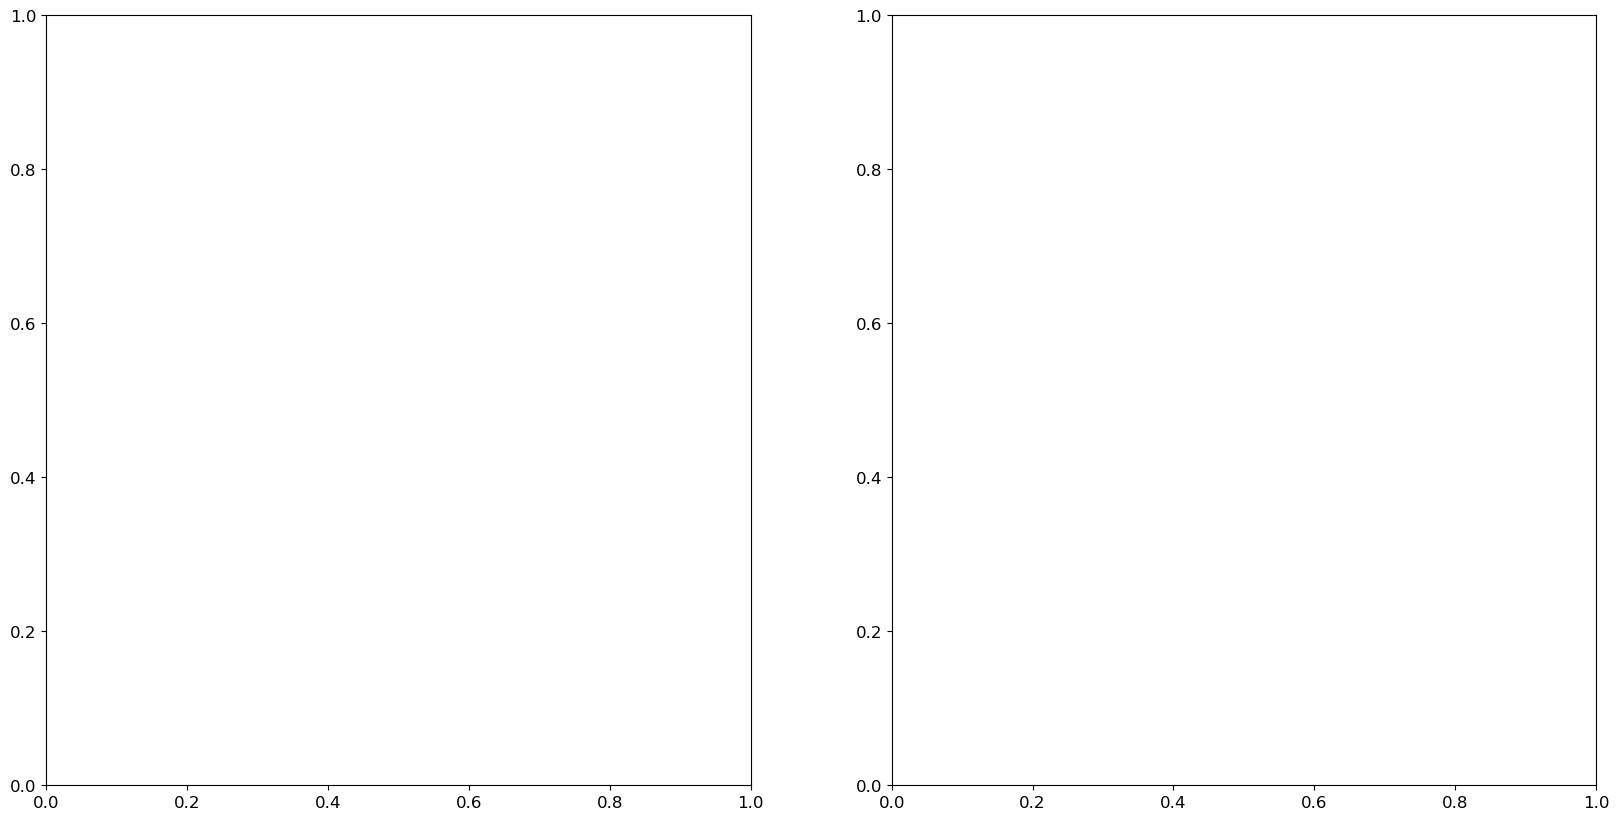

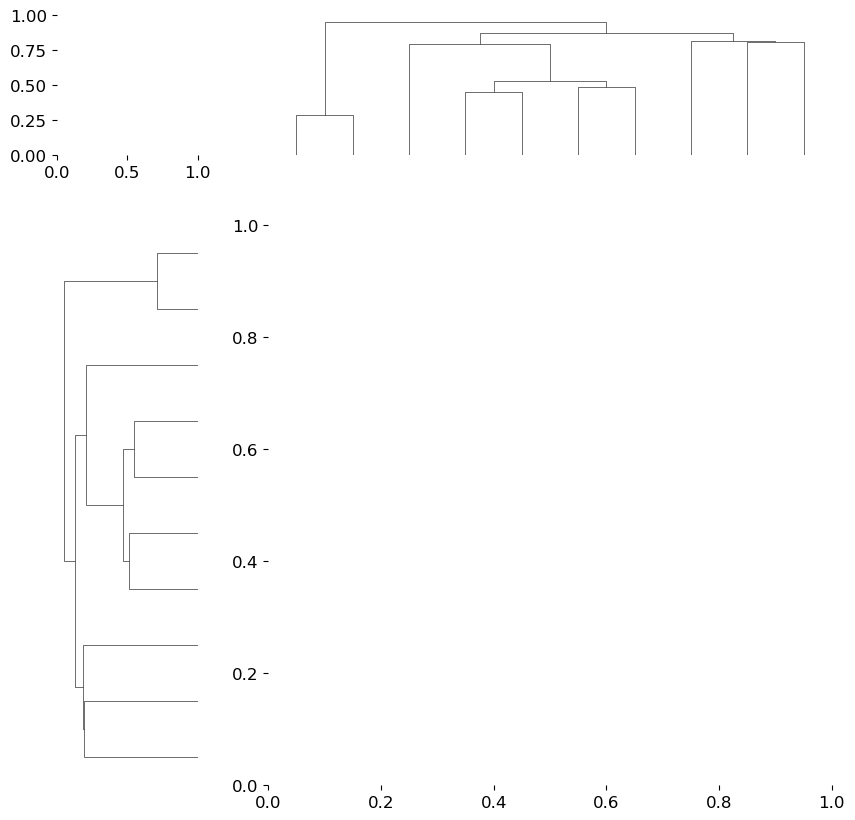

In [24]:
import seaborn as sns

fig, ax = plt.subplots(1,2,figsize=(20,10))

# "Cygni" are star systems/extrasolar planets and thus are expected to be similar
# the time periods have some similarity
sns.clustermap(cosine_sim.iloc[10:20, 10:20], ax=ax[0])

# "Cancri" are exoplanets and thus are expected to be similar
# we again see similarity between time periods
sns.clustermap(cosine_sim.iloc[50:60, 50:60], ax=ax[1])

In [25]:
def get_path_cosine_similarity(path: str, matrix: pd.DataFrame, method: str='sequential') -> list:
    """this function takes a navigation path string and returns an array of the Cosine Similarity.
       Two methods are supported: 'sequential' (default) which measures the sequential similarity and 
       'target' which measures the similarity between the current article at the target article.
       
       Input:
       path: navigation path string
       matrix: pre-computed Cosine Similarity matrix
       method: measurement method (defaults to 'sequential')
       
       Return:
       list: list of similarity measures
    """
    
    # there is 1 article that is duplicated in the plaintext folder. Problematically, the duplicated
    # article has different names and navigation paths can point to these different names, yet the 
    # article is the same. This one exception is handled here. In the implementation, we do not have to 
    # worry about this particular article pointing back to itself as it is not possible
    
    # navigation paths are separated by ";"
    path = path.split(';')
    
    # if the path only contains the starting article, return None
    if len(path) == 1:
        return None
    
    path_sims = []
    
    def get_correct_name(query: str, base_path: str=data_path + 'plaintext_articles') -> str:
        """this nested function is called in case a path contains error characters.
           Returns the fixed path so it can be used to query the Cosine Similarity matrix."""
        if '_' in query and '%' not in query:
            return query
        elif query in ['Podcasting', 'Color', 'Fencing', 'Anemia', 'Quito']:
            return query
        else:
            with open(os.path.join(base_path, f'{query}.txt'), 'r') as f:
                out = f.readlines()[2].replace('\n', '')
                return out
     
    # compute the similarity between sequential nodes
    # output list length is N-1
    if method == 'sequential':
        for i in range(0, len(path)-1):
            path_sims.append(
                matrix
                .loc[path[i]] 
                .loc[path[i+1]]
            )
            
    elif method == 'target':
        for i in range(0, len(path)):
            path_sims.append(
                matrix
                .loc[path[i]] 
                .loc[path[-1]]
            )
    return path_sims

In [26]:
# Illustrate with one path
print(final_df.iloc[0].path)
print("\nsequential method")
print(get_path_cosine_similarity(path=final_df.iloc[0].path,
                           matrix=cosine_sim,
                           method='sequential'))

print("\ntarget method")
print(get_path_cosine_similarity(path=final_df.iloc[0].path,
                           matrix=cosine_sim,
                           method='target'))

14th century;15th century;16th century;pacific ocean;atlantic ocean;accra;africa;atlantic slave trade;african slave trade

sequential method
[0.1434755285068337, 0.45464585584987954, 0.043109786306618575, 0.3241295725512904, 0.03354896797367541, 0.0703123602997387, 0.3571148831150813, 0.8001367430042642]

target method
[0.030770302481984573, 0.027690053831530274, 0.04952988433715528, 0.065975047345776, 0.10221112870993768, 0.035592432015227056, 0.36632283218041695, 0.8001367430042642, 1.0000000000000016]


In [27]:
# calculate the "sequential" and "target" cosine similarities and augment the DataFrame with these metrics
final_df['path_seq_cosine_sim'] = final_df['path'].apply(lambda x: get_path_cosine_similarity(x, matrix=cosine_sim))
final_df['path_target_cosine_sim'] = final_df['path'].apply(lambda x: get_path_cosine_similarity(x, matrix=cosine_sim, method='target'))

final_df.head(3)

,path,source_article,target_article,human_path_length,shortest_path_length,is_successful,top,center_top,center,center_bottom,bottom,count_images,path_seq_cosine_sim,path_target_cosine_sim
0,14th century;15th century;16th century;pacific...,14th century,african slave trade,8,3,1,1,2,1,1,4,7,"[0.1434755285068337, 0.45464585584987954, 0.04...","[0.030770302481984573, 0.027690053831530274, 0..."
1,14th century;europe;africa;atlantic slave trad...,14th century,african slave trade,4,3,1,1,1,1,2,0,3,"[0.06712629693232744, 0.20733258691597295, 0.3...","[0.030770302481984573, 0.10438905934281431, 0...."
2,14th century;niger;nigeria;british empire;slav...,14th century,african slave trade,7,3,1,7,0,0,1,0,5,"[0.04485369713543547, 0.16274390504642003, 0.1...","[0.030770302481984573, 0.04555201824451026, 0...."


In [28]:
# next, write a function that returns whether the Cosine similarities in a navigation path are increasing/decreasing
def sims_to_bool_path(path: str):
    """this function takes a navgiation path as input and returns the path with same dimensions
       containing Booleans denoting whether the Cosine similarity is increasing"""
    bool_path = []
    for idx in range(len(path)-1):
        if path[idx+1] > path[idx]:
            bool_path.append(True)
        else:
            bool_path.append(False)
    
    return bool_path

final_df['path_seq_boolean'] = final_df['path_seq_cosine_sim'].apply(sims_to_bool_path)
final_df['path_target_boolean'] = final_df['path_target_cosine_sim'].apply(sims_to_bool_path)

final_df.head(3)

# this function filters paths that only contain strictly increasing Cosine similarities
def filter_strictly_increasing_sims(path_list: list):
    return False if False in path_list else True

final_df['seq_strictly_increasing'] = final_df['path_seq_boolean'].apply(filter_strictly_increasing_sims)
final_df['target_strictly_increasing'] = final_df['path_target_boolean'].apply(filter_strictly_increasing_sims)

final_df.head(3)

,path,source_article,target_article,human_path_length,shortest_path_length,is_successful,top,center_top,center,center_bottom,bottom,count_images,path_seq_cosine_sim,path_target_cosine_sim,path_seq_boolean,path_target_boolean,seq_strictly_increasing,target_strictly_increasing
0,14th century;15th century;16th century;pacific...,14th century,african slave trade,8,3,1,1,2,1,1,4,7,"[0.1434755285068337, 0.45464585584987954, 0.04...","[0.030770302481984573, 0.027690053831530274, 0...","[True, False, True, False, True, True, True]","[False, True, True, True, False, True, True, T...",False,False
1,14th century;europe;africa;atlantic slave trad...,14th century,african slave trade,4,3,1,1,1,1,2,0,3,"[0.06712629693232744, 0.20733258691597295, 0.3...","[0.030770302481984573, 0.10438905934281431, 0....","[True, True, True]","[True, True, True, True]",True,True
2,14th century;niger;nigeria;british empire;slav...,14th century,african slave trade,7,3,1,7,0,0,1,0,5,"[0.04485369713543547, 0.16274390504642003, 0.1...","[0.030770302481984573, 0.04555201824451026, 0....","[True, False, True, True, True, True]","[True, True, True, True, False, True, True]",False,False


<font color='red' size='5'>
Featurization c. Similarity between distinct human paths through graph theory-inspired features.
</font>

So far we've focused on describing whether a given player used some of our proposed strategies or not. However to tell anything about the effectiveness of such strategies, we need to perform a matching analysis, as in this observational study the data is very biased: the distribution of successful paths is different from that of unsuccessful ones.


For this, we need a way of assessing the similarity between two different paths, and we will do so using only local features of the paths, in the context of the whole network. In particular, we'll use the concept of edge curvature (in particular Forman-Ricci curvature, see [1](https://match.pmf.kg.ac.rs/electronic_versions/Match80/n3/match80n3_605-622.pdf), [2](https://arxiv.org/pdf/1605.04662.pdf), and [3](https://arxiv.org/pdf/1811.07825.pdf)), which describes the ammount of flow that goes through a given edge, in a directed graph, and is defined as:  
<br>


<font size='4'>
\begin{align*}
F(_\rightarrow e_\rightarrow) &= 2 - in(i) - out(j)
\end{align*}
</font>
<br>
With this definition, we featurize each path and accordingly use the features to calculate propensity scores in each matching study.

In [29]:
# Load graph 

df_links = (pd.read_csv(data_path + "wikispeedia_paths-and-graph/links.tsv", 
                        skiprows=12, 
                        sep="\t", 
                        header=None)
            .applymap(str_url_format)
            .rename(columns={0:"src",
                             1:"tgt"})
           )

def split_decode_path(path):
    return list(map(
        str_url_format, 
        path.split(";")
    ))

df_paths_success = (pd.read_csv(data_path + "wikispeedia_paths-and-graph/paths_finished.tsv", 
                          skiprows=15, 
                          sep="\t", 
                          header=None)
                    .rename(columns={0:"ip",
                                     1:"timestamp",
                                     2:"duration",
                                     3:"path",
                                     4:"rating"})
         )
# Create a "target" col
df_paths_success["target"] = (df_paths_success["path"]
                              .apply(lambda x: (str_url_format(x)
                                                .split(";")[-1])))
df_paths_success["type"] = "win"


df_paths_fail = (pd.read_csv(data_path + "wikispeedia_paths-and-graph/paths_unfinished.tsv", 
                             skiprows=16, 
                             sep="\t", 
                             header=None)
                 .rename(columns={0:"ip",
                                  1:"timestamp",
                                  2:"duration",
                                  3:"path",
                                  4:"target",
                                  5:"type"})
             )

# Join dfs to get a full df with all paths
df_paths = pd.concat([df_paths_success,
                      df_paths_fail])

# Get path list
df_paths["pathl"] = df_paths["path"].apply(split_decode_path)
# Decode target from url
df_paths["target"] = df_paths["target"].apply(str_url_format)
# Get starting node
df_paths["start"] = df_paths["pathl"].apply(lambda x:x[0])

df_paths.sample(5)

,ip,timestamp,duration,path,rating,target,type,pathl,start
23613,609f3735581016e0,1385085170,154,Tiger_Woods;Michael_Jordan;Looney_Tunes;DVD;Co...,NaN,alfred hitchcock,restart,"[tiger woods, michael jordan, looney tunes, dv...",tiger woods
46593,35175188146c214f,1351388445,258,Scrooge_McDuck;Scotland;Ireland;Folk_music;Sco...,3.0,loch,win,"[scrooge mcduck, scotland, ireland, folk music...",scrooge mcduck
3671,7aa81cc37d505dac,1305872823,192,Pyramid;Mesopotamia;Irrigation;<;Barley;Cereal...,NaN,bean,restart,"[pyramid, mesopotamia, irrigation, <, barley, ...",pyramid
36239,1f4e55692f614bb4,1249429217,132,Cactus;Aztec;Mexico_City;United_States;Educati...,3.0,muhammad ibn musa al-khwarizmi,win,"[cactus, aztec, mexico city, united states, ed...",cactus
40884,424f77430336d383,1250007045,75,Investment_banking;United_Kingdom;Europe;Italy...,3.0,dante alighieri,win,"[investment banking, united kingdom, europe, i...",investment banking


In [30]:
# Merge all dfs that count node properties:
# in-degree, out-degree, use as start, use as target

freq_out = df_links['src'].value_counts()
freq_in = df_links['tgt'].value_counts()

degree_freq = (pd.merge(freq_in,
                        freq_out, 
                        left_index=True, 
                        right_index=True, 
                        how='outer')
               .fillna(0)
               .rename(columns={"src":"out",
                                "tgt":"in"}))

from itertools import chain
degree_connect = (
    degree_freq
    .merge(
        # Count how many times an article was used as target
        df_paths["target"].value_counts(),
        left_index=True,
        right_index=True,
        how="outer"
    )
    .merge(
        # Count how many times an article was used as starting point
        df_paths["start"].value_counts(), 
        left_index=True, 
        right_index=True,
        how="outer")
    .merge(
        # Count how many times an article was clicked
        pd.Series(
            list(chain(
                *df_paths["pathl"].values
            )), 
            name="clicks"
        )
        .value_counts(), 
        left_index=True, 
        right_index=True,
        how="outer")
)

degree_connect

,in,out,target,start,clicks
1 ceres,12.0,32.0,11.0,7.0,137.0
10th century,65.0,26.0,7.0,13.0,150.0
11th century,57.0,48.0,13.0,17.0,141.0
12th century,85.0,45.0,10.0,25.0,169.0
13th century,84.0,34.0,34.0,13.0,175.0
...,...,...,...,...,...
åland,0.0,19.0,NaN,NaN,4.0
édouard manet,0.0,20.0,NaN,NaN,7.0
éire,0.0,8.0,NaN,NaN,13.0
óengus i of the picts,0.0,10.0,NaN,NaN,NaN


In [31]:
# Let's calculate curvature for each edge in the graph

# get in-degree(`in`) and out-degree(`out`)
curv_edge = (
    df_links
    .merge(
        (degree_connect[["in"]]
         .rename(columns={"in":"in-degree(src)"})),
        left_on="tgt", 
        right_index=True,
        how="outer")
    .merge(
        (degree_connect[["out"]]
         .rename(columns={"out":"out-degree(tgt)"})),
        left_on="src", 
        right_index=True,
        how="outer")
)

# Calculate curvature
curv_edge["curvature"] = 2 - curv_edge["in-degree(src)"] - curv_edge["out-degree(tgt)"]

curv_edge.sample(5)

,src,tgt,in-degree(src),out-degree(tgt),curvature
91633.0,rhodium,hydrogen,155.0,34.0,-187.0
52716.0,human rights,buddhism,144.0,71.0,-213.0
40567.0,fossil,amber,17.0,24.0,-39.0
30395.0,desert locust,spain,539.0,46.0,-583.0
70906.0,max weber,business,44.0,48.0,-90.0


### How does the distribution of edge curvatures look like?

The distribution below looks very interesting, as it shows several peaks of the distribution towards the left. This is very different from what we see in the node in- and out-degree distributions to the right. This may indicate that curvature is much more informative than simple in- and out- degrees, despite of it's simplicity.


The characteristics of these bumps may be interesting (and in fact we found that they are related to connectivity with highly connected nodes, or hubs, in different degrees. There might even be a connection with some sort of concept hierarchy, where the nodes with a more negative curvature correspond to very important concepts or topics, while the overall importance of the concepts decrease as the curvature approaches 0. This can also be seen as the concepts becoming more specific. For instance, we found that the last bump to the left is associated with the article 'United States', and the one following comprises some continents and some european countries like germany and france.)

SyntaxError: Python keyword not valid identifier in numexpr query (<unknown>, line 1)

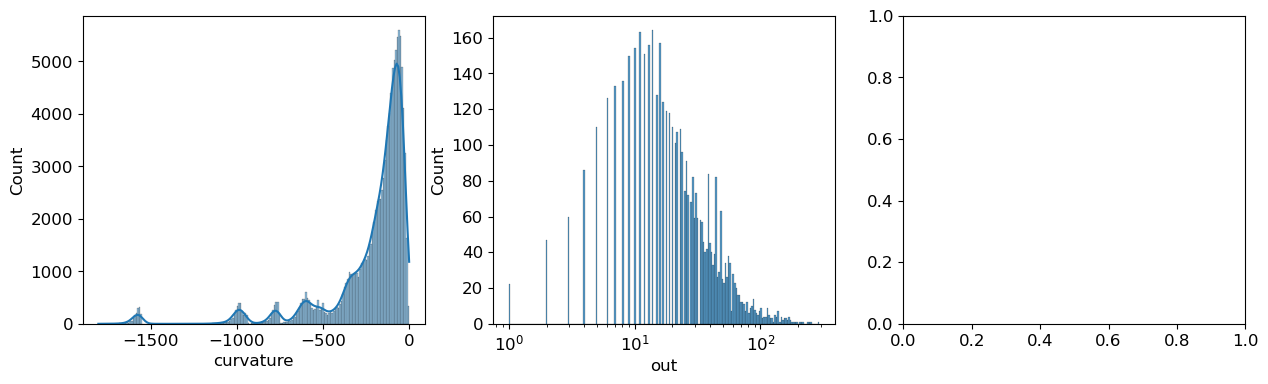

In [32]:
fig, ax = plt.subplots(1,3,figsize=(15, 4))

sns.histplot(data=curv_edge, 
             x="curvature", 
             bins=200, 
             ax=ax[0], 
             kde=True)

sns.histplot(data=degree_connect.query("out!=0"), 
             x="out", 
             bins=200, 
             ax=ax[1], 
             log_scale=True)

sns.histplot(data=degree_connect.query("in!=0"), 
             x="in", 
             bins=200, 
             ax=ax[2], 
             log_scale=True)

ax[0].set_xlabel("Edge curvature")
ax[1].set_xlabel("Node out-degree")
ax[2].set_xlabel("Node in-degree")

In [33]:
# ADD features to final df

# First get, for every path, a sequence of nodes.

# For convenience, let's drop paths contatining '<' for now
df_paths_clean = (final_df[final_df["path"]
                           .apply(lambda x: '<' not in x)])
df_paths_clean["pathl"] = df_paths_clean.path.str.split(";")

def list_nodes(pathl):
    return [
        [pathl[i],pathl[i+1]]
        for i in range(len(pathl)-1)
    ]
    
# Array to index edge -> curvature 
indx_curva = (curv_edge
              .set_index(["src", "tgt"])
              .loc[:,"curvature"])
def path_curvature(row):
    try:
        return (indx_curva
                .loc[row["edgel"]]
                .values)
    except:
        return []

df_paths_clean["edgel"] = df_paths_clean["pathl"].apply(list_nodes)
df_paths_clean["path_curv"] = df_paths_clean.apply(path_curvature, axis=1)

df_paths_clean.head(3)

,path,source_article,target_article,human_path_length,shortest_path_length,is_successful,top,center_top,center,center_bottom,...,count_images,path_seq_cosine_sim,path_target_cosine_sim,path_seq_boolean,path_target_boolean,seq_strictly_increasing,target_strictly_increasing,pathl,edgel,path_curv
0,14th century;15th century;16th century;pacific...,14th century,african slave trade,8,3,1,1,2,1,1,...,7,"[0.1434755285068337, 0.45464585584987954, 0.04...","[0.030770302481984573, 0.027690053831530274, 0...","[True, False, True, False, True, True, True]","[False, True, True, True, False, True, True, T...",False,False,"[14th century, 15th century, 16th century, pac...","[[14th century, 15th century], [15th century, ...","[-129.0, -180.0, -274.0, -335.0, -130.0, -488...."
1,14th century;europe;africa;atlantic slave trad...,14th century,african slave trade,4,3,1,1,1,1,2,...,3,"[0.06712629693232744, 0.20733258691597295, 0.3...","[0.030770302481984573, 0.10438905934281431, 0....","[True, True, True]","[True, True, True, True]",True,True,"[14th century, europe, africa, atlantic slave ...","[[14th century, europe], [europe, africa], [af...","[-962.0, -634.0, -225.0, -63.0]"
2,14th century;niger;nigeria;british empire;slav...,14th century,african slave trade,7,3,1,7,0,0,1,...,5,"[0.04485369713543547, 0.16274390504642003, 0.1...","[0.030770302481984573, 0.04555201824451026, 0....","[True, False, True, True, True, True]","[True, True, True, True, False, True, True]",False,False,"[14th century, niger, nigeria, british empire,...","[[14th century, niger], [niger, nigeria], [nig...","[-94.0, -148.0, -207.0, -245.0, -577.0, -225.0..."


In [34]:
import numpy as np


final_df_curv = df_paths_clean.drop(columns=["pathl", "edgel"])

def curv_features(path_curv):
    """
    Calculate curvature features of a path.
    
    With the curvature of the edges in the path, calc a fixed length vector that (approx) describes it.
    """
    path_curv = pd.Series(path_curv, dtype=np.float64)
    p_curv_diff = np.diff(path_curv)
    
    descr = path_curv.describe()
    descr2 = pd.Series(p_curv_diff).describe()
    
    return pd.concat([descr, descr2]).reset_index(drop=True)


curv_feats = final_df_curv["path_curv"].apply(curv_features)

final_df_curv = pd.concat([final_df_curv
                           .drop(columns="path_curv"),
                           curv_feats],
                          axis=1)

final_df = final_df_curv.rename(columns={i:f"curv_feats_{i}" for i in range(16)})

final_df.to_csv("processed/final_df_curv_feats.csv", index=False)
final_df.head(3)

KeyboardInterrupt: 

---

# 4. Statistical analysis

### Calculation of propensity score 

The purpose motivating the matched analysis is to obtain a "balanced" testing dataset, with subjects actually comparable. In fact, we want to test potential correlation between specific strategies performed and players' success. The players tested should then be at the same starting point when choosing what strategy to adopt, i.e. have same probability to get the treatment (a.k.a. propensity score).


The **propensity scores** are obtained by calculating the **predicted outcomes of a logistic regression** with the dependent variable being the boolean treatment variable `treat` and the independent variables being selected features, based on the curvature of each edge on the given path.

As a starting point, to generate features with a fixed length (independent of path length), we use the `describe` method on the list of path curvatures, and on the sequential difference of path curvatures.


With this, we obtain as independent features:

- path length
- maximum edge curvature
- minimum edge curvature
- average edge curvature
- maximum change in curvature
- minimum change in curvature


Among others. In total, the paths are described by 16 numeric features.
<br>

The **treated subject** is the user performing the specific strategy, the **controlled subject** is the user NOT performing the specific startegy. The following tretments will be tested:
1. Players clicking in hyperlinks showing up at the top of articles;
2. Players clicking in hyperlinks showing up at the top-center of articles;
3. Players clicking on hyperlinks showing up in image captions;
4. Players clicking articles with sequentially increasing similarity between the two;
5. Players clicking articles with increasing similarity with the target article;

The **label** is players' success `is_successful`.

In [ ]:
# Let's center our attention on paths with optimum length == 4
# Here tasks are harder, and so classes (succcess/unsuccess) are more balanced.
# Also less data -> matching is faster

final_df_filt = final_df.query("shortest_path_length == 4")
final_df_filt.is_successful.value_counts()

In [ ]:
import networkx as nx
from tqdm.notebook import tqdm

def get_similarity(propensity_score1, propensity_score2):
    '''Calculate similarity for instances with given propensity scores'''
    return 1-np.abs(propensity_score1-propensity_score2)

### Matching

We will perform several matching studies, to test whether each particular strategy works or not.

We'll center the attention on:

- top
- bottom
- center-bottom
- increasing sequential semantic similarity
- increasing target semantic similarity

We disregard the strategies `center-top` and `center` as they are the less popular.

Additionally, we will take a random sample of the unmatched dataset (of around 3000 samples). The reason for this is that each matching takes a very long time to run, so by randomly sampling we keep a similar distribution of samples while reducing the computational burden.

In [ ]:
final_df_filt = (pd.read_csv("processed/final_df_curv_feats.csv")
                 .query("shortest_path_length == 4")
                 .dropna()
                 .sample(3000))

In [ ]:
# Function for matching

def matching_dataset(strategy, treatment_df, control_df):
    
    print("Generating matching graph")
    # Create an empty undirected graph
    G = nx.Graph()
    
    # Loop through all the pairs of instances
    for control_id, control_row in tqdm(control_df.iterrows(), 
                                        total=control_df.shape[0]):
        for treatment_id, treatment_row in treatment_df.iterrows():
    
            # We control for task difficulty (more general in case we don't pre-filter)
            if control_row["shortest_path_length"] == treatment_row["shortest_path_length"]:
                # Calculate the similarity 
                similarity = get_similarity(control_row[f'prop_scores_{strategy}'],
                                            treatment_row[f'prop_scores_{strategy}'])
                # Add an edge between the two instances weighted by the similarity between them
                G.add_weighted_edges_from([(control_id, treatment_id, similarity)])
    
    # Generate and return the maximum weight matching on the generated graph
    print(f"Calculating max weight matching for {strategy}")
    matching = nx.max_weight_matching(G)
                
    idxs = list(chain(*matching))
    matched_df = final_df_filt.loc[idxs]
    
    matched_df.to_csv(f'processed/matched_df_{strategy}.csv', index=False)
    return matched_df

In [ ]:
import statsmodels.api
import statsmodels.formula.api as smf
from itertools import chain 

# Tell whether path followed strategy or not
for strategy in ['top', 'center_bottom', 'bottom', 'count_images']:
    final_df_filt[f'used_{strategy}'] = ((final_df_filt[strategy]/final_df_filt.human_path_length) > 0.5)*1
    
    
matched_dfs = {}
results = {}
# Perform a matching analysis for each strategy
for strategy in ['used_top',
                 'used_center_bottom',
                 'used_bottom',
                 'used_count_images',
                 'seq_strictly_increasing',
                 'target_strictly_increasing']:
    
    print("\n###############################################")
    print(f"Preparing dataset for regression: {strategy}")
    y_treatment = final_df_filt[strategy]*1
    X_feats = (final_df_filt
               .loc[:,(final_df_filt
                       .columns
                       .str
                       .startswith("curv_feats"))]
              )      

    X_feats = (X_feats - X_feats.mean(axis=0))/X_feats.std(axis=0)
    
    # Calc prop score (w logistic regr)
    df_regr = pd.concat([X_feats, y_treatment.rename("treat")], 
                        axis=1)
    
    
    print(f"Fitting logistic regression for propensity score: {strategy}")
    model = smf.logit(formula='treat ~ '+ '+'.join(X_feats.columns), data=df_regr)
    # BFGS algo prevents linalg error
    res = model.fit(method='bfgs') 
    
    # Add treatment flag to df
    final_df_filt[f"treatment_{strategy}"] = y_treatment
    
    # Add prop score to df
    final_df_filt[f"prop_scores_{strategy}"] = res.predict()
    
    # Separate the treatment and control groups
    treatment_df = final_df_filt[final_df_filt[f'treatment_{strategy}'] == 1]
    control_df = final_df_filt[ final_df_filt[f'treatment_{strategy}'] == 0]
    
    print(f"Performing matching")
    matched_dfs[strategy] = matching_dataset(strategy, treatment_df, control_df)
    

    print(f"Fitting logistic regression for statistical test: {strategy}")
    # Logistic regression to test statistical difference between the treated and control groups.
    mod = smf.logit(formula = f'is_successful ~ C(treatment_{strategy})', data=matched_dfs[strategy])
    # BFGS algo prevents linalg error
    res = mod.fit(method='bfgs')
    
    
    # dictionary to store the coefficients and p-values of the current experiment
    curr_analysis = {}
    # store the intercept
    curr_analysis['Intercept'] = res.params[0]
    # store the intercept p-value
    curr_analysis['Intercept p-value'] = res.pvalues[0]
    # store the coefficient for **strictly increasing Cosine similarity**
    curr_analysis['Coefficient'] = res.params[1]
    # store the coefficient p-value
    curr_analysis['Coefficient p-value'] = res.pvalues[1]
    
    results[strategy] = curr_analysis
    
results_df = pd.DataFrame(results)

In [ ]:
results_df = pd.DataFrame(results)
results_df.to_csv("processed/results_matching.csv", index=True)
results_df

## Conclusion

Our analysis indicates that, indeed, different strategies lead to different results. As can be seen from the `coefficient p-values`, a significant effect (p-value < 0.05) is only found for the treatments `used_bottom` and `target_strictly_increasing`. The others show values way higher than this, which indicates that the *isolated* use of the other strategies has no effect on the final outcome.

The strategy of clicking links located to the bottom of the page (`used_bottom`) has, however, a negative influence, that is, the use of this strategy is against a successful game, so its use is discouraged. This can be rationalized considering that links in the bottom of the page tend to be more context-specific and not as general, so only few concepts can be reached by clicking these links.

The strategy of increasing similarity to the target article shows a large positive coefficient (~0.37), which indicates that this strategy is indeed a good predictor of success. It is intuitively reasonable as the result states that rationality and common sense knoledge lead to success.